In [ ]:
!pip install -qU diffusers accelerate transformers huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Load schedulers and models

* The **schedulers** encapsulate the entire denoising process such as the number of denoising steps and the algorithm for finding the denoised sample. They are not parameterized or trained so they do not take much memory.
* The **models** are usually only concerned with the forward pass of going from a noisy input to a less noisy sample.

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    torch_dtype=torch.float16,
    use_safetensors=True,
).to('cuda')

We can check the scheduler profile:

In [ ]:
pipeline.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.32.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

## Load a scheduler

Schedulers are defined by a configuration file that can be used by a variety of schedulers.

For example, we can load the `DDIMScheduler`:

In [ ]:
from diffusers import DDIMScheduler, DiffusionPipeline

ddim = DDIMScheduler.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    subfolder='scheduler',
)

then we can pass it to the pipeline

In [ ]:
pipeline = DiffusionPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    scheduler=ddim, # newly loaded scheduler
    torch_dtype=torch.float16,
    use_safetensors=True,
).to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Compare schedulers

We can call `pipeline.scheduler.compatibles` attribute to see what schedulers are compatible with a pipeline.

In [ ]:
pipeline.scheduler.compatibles

[diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_edm_euler.EDMEulerScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DP

In this section, we will compare different schedulers on the same prompt and seed below.

In [ ]:
import torch
from diffusers import DiffusionPipeline

# default pipeline
pipeline = DiffusionPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    torch_dtype=torch.float16,
    use_safetensors=True,
).to('cuda')

# default prompt and seed
prompt = "A photograph of an astronaut riding a horse on Mars, high resolution, high definition."
generator = torch.Generator('cuda').manual_seed(111)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# default scheduler
pipeline.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.32.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

#### `LMSDiscreteScheduler`

Typically generates higher quality images than the default scheduler.

  0%|          | 0/50 [00:00<?, ?it/s]

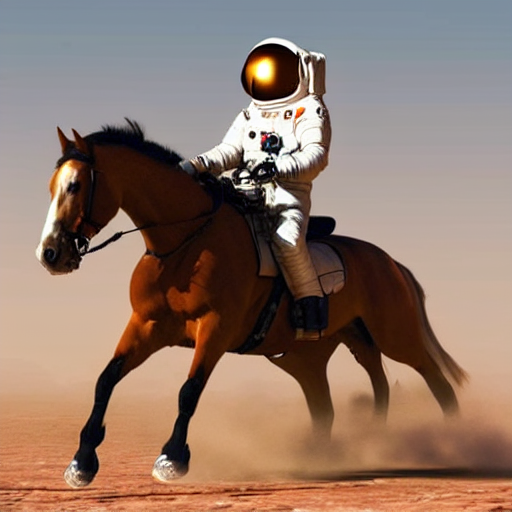

In [ ]:
from diffusers import LMSDiscreteScheduler

pipeline.scheduler = LMSDiscreteScheduler.from_config(
    pipeline.scheduler.config
)

image = pipeline(prompt, generator=generator).images[0]
image

#### `EulerDiscreteScheduler`

generate higher quality images in just 30 steps

  0%|          | 0/50 [00:00<?, ?it/s]

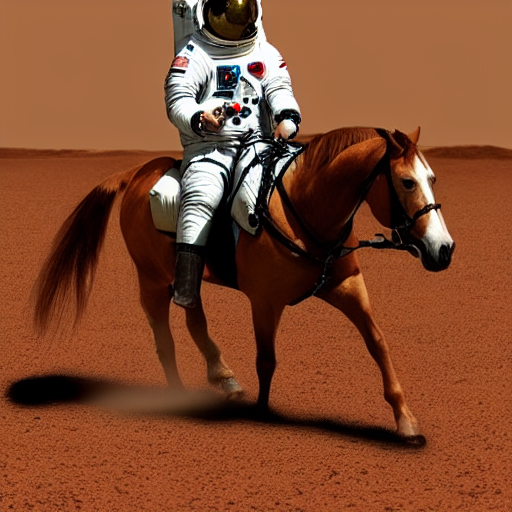

In [ ]:
from diffusers import EulerDiscreteScheduler

pipeline.scheduler = EulerDiscreteScheduler.from_config(
    pipeline.scheduler.config
)

image = pipeline(prompt, generator=generator).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

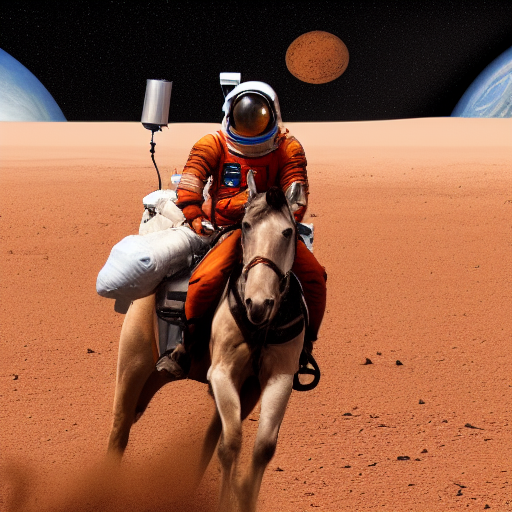

In [13]:
pipeline.scheduler = EulerDiscreteScheduler.from_config(
    pipeline.scheduler.config
)

image = pipeline(
    prompt,
    num_inference_steps=30,
    generator=generator,
).images[0]
image

#### `EulerAncestralDiscreteScheduler`

similar to `EulerDiscreteScheduler`

  0%|          | 0/50 [00:00<?, ?it/s]

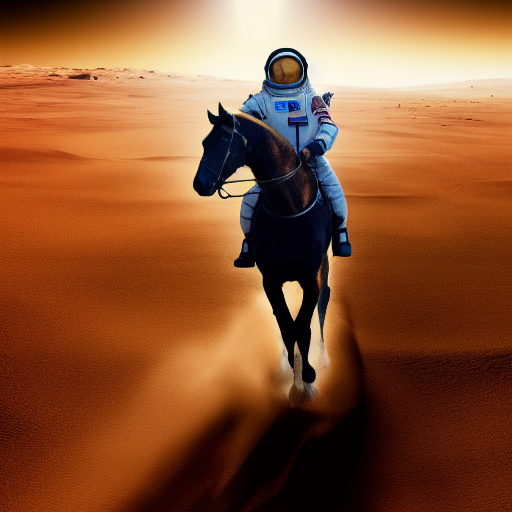

In [ ]:
from diffusers import EulerAncestralDiscreteScheduler

pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipeline.scheduler.config
)

image = pipeline(prompt, generator=generator).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

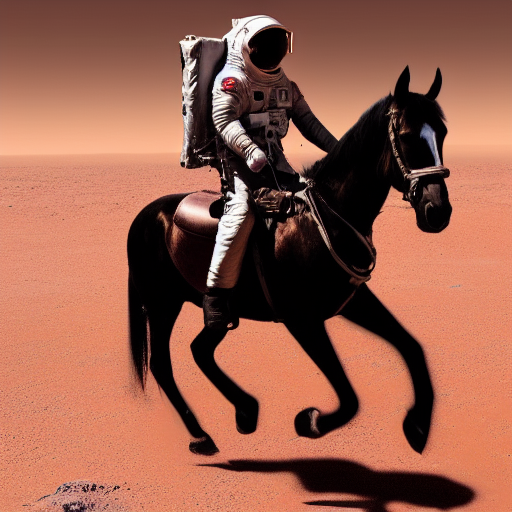

In [14]:
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipeline.scheduler.config
)

image = pipeline(
    prompt,
    num_inference_steps=30,
    generator=generator,
).images[0]
image

#### `DPMSolverMultistepScheduler`

provide a balance between speed and quality. can generate high quality images in just 20 steps.

  0%|          | 0/50 [00:00<?, ?it/s]

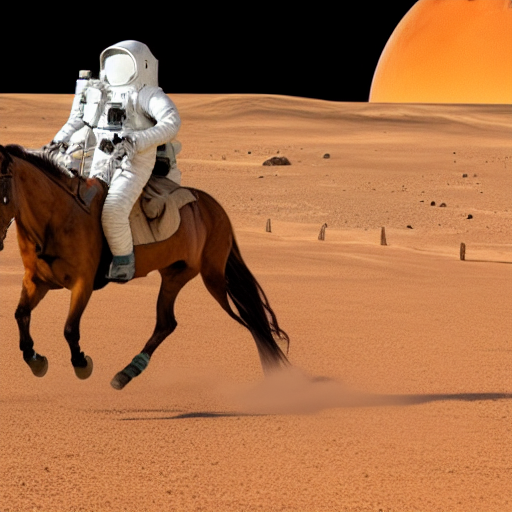

In [ ]:
from diffusers import DPMSolverMultistepScheduler

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    pipeline.scheduler.config
)

image = pipeline(prompt, generator=generator).images[0]
image

  0%|          | 0/20 [00:00<?, ?it/s]

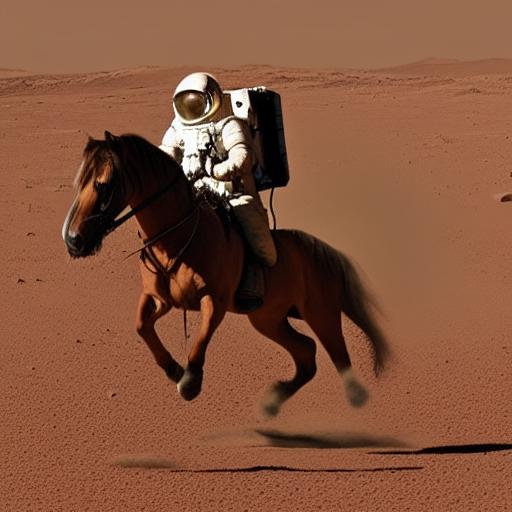

In [15]:
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    pipeline.scheduler.config
)

image = pipeline(
    prompt,
    num_inference_steps=20,
    generator=generator,
).images[0]
image

### Flax schedulers

To compare Flax schedulers, we need to load the scheduler state into the model parameters.

In [ ]:
import jax
import numpy as np
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from diffusers import FlaxStableDiffusionPipeline, FlaxDPMSolverMultistepScheduler

scheduler, scheduler_state = FlaxDPMSolverMultistepScheduler.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    subfolder="scheduler"
)
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    scheduler=scheduler,
    variant="bf16",
    dtype=jax.numpy.bfloat16,
)
params["scheduler"] = scheduler_state

Then we can generate images in parallel with Flax's compatibility with TPU.

In [ ]:
# Generate 1 image per parallel device (8 on TPUv2-8 or TPUv3-8)
prompt = "A photograph of an astronaut riding a horse on Mars, high resolution, high definition."
num_samples = jax.device_count()
prompt_ids = pipeline.prepare_inputs([prompt] * num_samples)

prng_seed = jax.random.PRNGKey(0)
num_inference_steps = 25

# shard inputs and rng
params = replicate(params)
prng_seed = jax.random.split(prng_seed, jax.device_count())
prompt_ids = shard(prompt_ids)

images = pipeline(prompt_ids, params, prng_seed, num_inference_steps, jit=True).images
images = pipeline.numpy_to_pil(np.asarray(images.reshape((num_samples,) + images.shape[-3:])))

## Models

In [ ]:
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    subfolder='unet',
)

In [ ]:
# load from a repository
from diffusers import UNet2DModel

unet = UNet2DModel.from_pretrained(
    'google/ddpm-cifar10-32',
    use_safetensors=True,
)

In [ ]:
# load and save a variant
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="unet", variant="non_ema", use_safetensors=True
)
unet.save_pretrained("./local-unet", variant="non_ema")